# Predict size of cluster from text content

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Tools for evaluating the model by running it repeatedly
# with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [4]:
# Load the corpus
df = pd.read_csv("working/RSS_kmeans_w2v_pca.csv")

In [5]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Reasign huge clusters as outliers
cs_lookup = df['cluster'].value_counts().to_dict()
df['cluster'] = df['cluster'].apply(lambda x: -1 if (cs_lookup[x] > 1000) else x)

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

#df = df[df['cluster'] != -1]
df['cluster_size'] = np.where(df['cluster']==-1, 1.0, df['cluster_size'])

# Sort by date-order, latest last!
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df = df.sort_values("date_clean")

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']].head()

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,cluster_size,tokens,phrased_tokens
7164,501.0,"[photo, saudi, arabia, doesnt, want, seen, pro...","[saudi_arabia, islam, mecca]"
898,423.0,"[luck, chang, billi, ray, harri, homeless, man...","[billi, ray, harri, harri]"
16117,390.0,"[prison, hell, gulf, princ, british, bodyguard...","[gulf, hasnain, ali, dubai]"
483,446.0,"[fire, turn, amazon, rainforest, desert, human...","[amazon, barren]"
16435,515.0,"[dresden, bomb, composit, imag, wwii, ruin, ge...","[wwii, dresden, septemb]"


In [6]:
# vectorizer = TfidfVectorizer(decode_error="ignore", max_features=1000)
vectorizer = CountVectorizer(decode_error="ignore", max_features=7000)

# Create feature vectors
X = vectorizer.fit_transform(df['phrased_tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data randomly, save 'test' for final pass
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data time-wise, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ensure that the training data is shuffled at random
X_train, y_train = shuffle(X_train, y_train, random_state=42)

(31393, 7000) (31393,)


In [7]:
# Define the measurements we want to make (GridSearch will default to MSE)
scoring = {'MSE': make_scorer(mean_squared_error),
           'R2': make_scorer(r2_score)}

parameters = {'alpha':[0.01, 0.03, 0.05, 0.07, 0.1, 0.5, 1.0, 2.0],
              'l1_ratio': [1.0]}

model = ElasticNet()

# Perform cross-validated grid-search
clf = GridSearchCV(estimator=model,
                   cv=5,
                   param_grid=parameters,
                   return_train_score=True,
                   scoring=scoring,
                   refit="R2",
                   n_jobs=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

In [8]:
# Look at the performance of each hyperparameter combination
pd.DataFrame(clf.cv_results_)\
  [['params', 'mean_test_R2', 'mean_test_MSE']]\
  .sort_values("mean_test_R2", ascending=False)

,params,mean_test_R2,mean_test_MSE
0,"{'alpha': 0.01, 'l1_ratio': 1.0}",0.345303,21912.732778
1,"{'alpha': 0.03, 'l1_ratio': 1.0}",0.306475,23214.350847
2,"{'alpha': 0.05, 'l1_ratio': 1.0}",0.274164,24295.829103
3,"{'alpha': 0.07, 'l1_ratio': 1.0}",0.251715,25047.087987
4,"{'alpha': 0.1, 'l1_ratio': 1.0}",0.229255,25798.858092
5,"{'alpha': 0.5, 'l1_ratio': 1.0}",0.178767,27487.821055
6,"{'alpha': 1.0, 'l1_ratio': 1.0}",0.151562,28398.503714
7,"{'alpha': 2.0, 'l1_ratio': 1.0}",0.102138,30053.093872


In [9]:
print("** VALIDATION RESULTS **")
for method_name, scorer in scoring.items():
    print(method_name, scorer(X=X_test, y_true=y_test, estimator=clf))

** VALIDATION RESULTS **
MSE 22363.639308801216
R2 0.3126077549500247


With all words; cv R2 = 0.24, val R2 = 0.36 (???)

With all non-nouns; cv R2 = 0.057, val R2 = 0.09

With nouns only; cv R2 = 0.31, val R2 = 0.45

With nouns only after remembering to shuffle the damn training data; cv R2 = 0.45, val R2 = 0.45
With nouns only after dropping outliers; cv R2 = 0.57, val R2 = 0.45

In [10]:
def help_get_coefs(fitted_model, feature_names):
    """
    Gets ordered table of coefficient names and magnitudes
    """
    df = pd.DataFrame({"name": feature_names,
                       "coefficient": fitted_model.coef_})
    
    # MAGNITUDES rather than VALUE determine importance
    df['abs_value'] = df['coefficient'].apply(abs)
    
    return df.sort_values("abs_value", ascending=False)


# In this call, retrieving final (selected and retrained)
# estimator from the grid search
coef_table = help_get_coefs(clf.best_estimator_, list(vectorizer.get_feature_names()))

coef_table

,name,coefficient,abs_value
4560,newfoundland,190.741743,190.741743
427,australia_australia,187.860543,187.860543
6772,wexner,-168.756748,168.756748
6934,york_new,168.616498,168.616498
434,australia_new,165.365124,165.365124
...,...,...,...
3201,jaipur,-0.000000,0.000000
3203,jairo,0.000000,0.000000
3205,jake,0.000000,0.000000
3208,jalisco_new,-0.000000,0.000000


In [11]:
coef_table.head(30)

,name,coefficient,abs_value
4560,newfoundland,190.741743,190.741743
427,australia_australia,187.860543,187.860543
6772,wexner,-168.756748,168.756748
6934,york_new,168.616498,168.616498
434,australia_new,165.365124,165.365124
1673,defenc_minist,164.345303,164.345303
3953,mall,163.687434,163.687434
3260,jeffrey_epstein,-160.990110,160.990110
5866,south_korea,-159.952607,159.952607
2150,fake,158.449302,158.449302


In [12]:
# How many features ultimately selected?
# (they're regularised to NEAR zero, so need a tolerance)
coef_table[coef_table['abs_value'] >= 2.0]

,name,coefficient,abs_value
4560,newfoundland,190.741743,190.741743
427,australia_australia,187.860543,187.860543
6772,wexner,-168.756748,168.756748
6934,york_new,168.616498,168.616498
434,australia_new,165.365124,165.365124
...,...,...,...
4385,mrwetyana,2.144995,2.144995
5615,scienc,2.128658,2.128658
6507,ukrain,-2.095775,2.095775
5702,shane,2.050428,2.050428


In [13]:
# What features suck?
coef_table[coef_table['abs_value'] <= 0.01]

,name,coefficient,abs_value
4227,mihigo,-3.284997e-04,3.284997e-04
4448,naga,2.147852e-04,2.147852e-04
4502,navratri_navratri,1.741384e-13,1.741384e-13
5001,politburo,-0.000000e+00,0.000000e+00
6467,tyler,0.000000e+00,0.000000e+00
...,...,...,...
3201,jaipur,-0.000000e+00,0.000000e+00
3203,jairo,0.000000e+00,0.000000e+00
3205,jake,0.000000e+00,0.000000e+00
3208,jalisco_new,-0.000000e+00,0.000000e+00


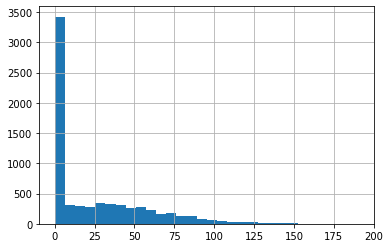

In [14]:
coef_table['abs_value'].hist(bins=30)

## Diagnostic Plots
I'm, to some degree, improvising my own because no single python package quite does everything I'd expect R to do for a linear regression...

In [15]:
sns.set_context("poster")

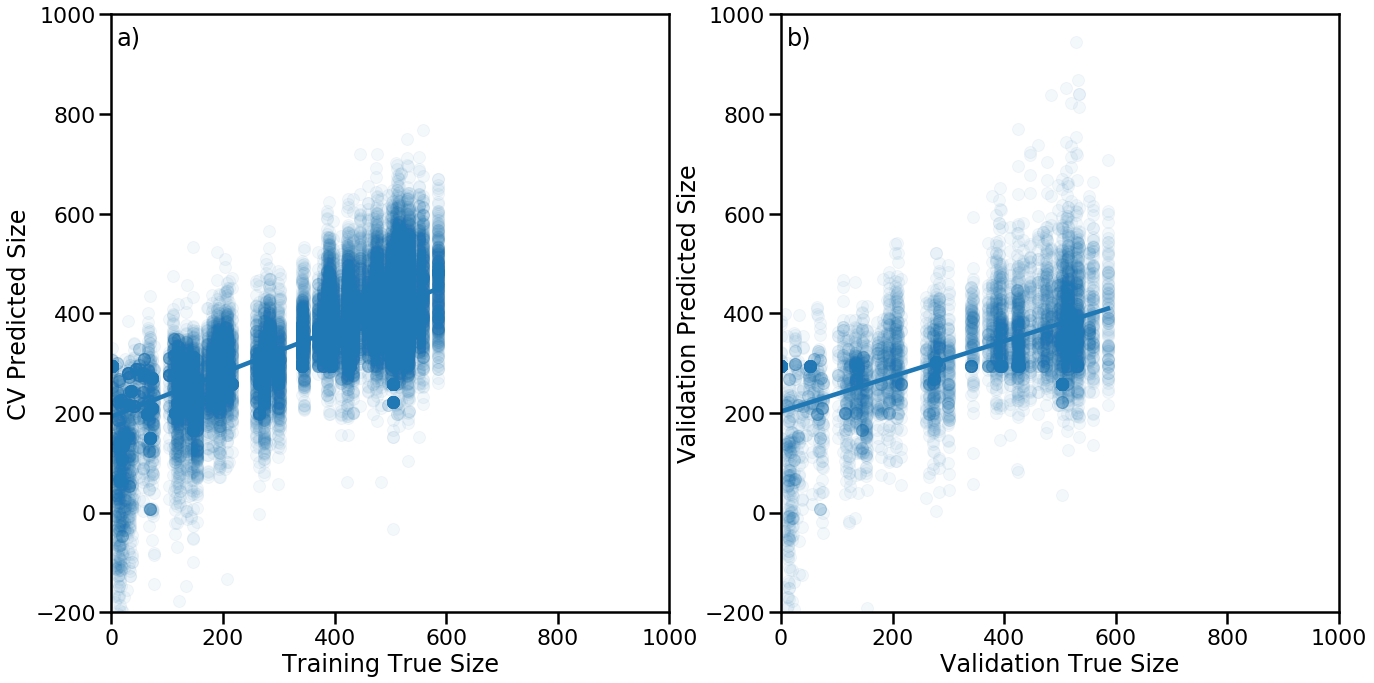

In [16]:
train_df = pd.DataFrame({"Training True Size": y_train,
                         "CV Predicted Size": y_pred})

test_df = pd.DataFrame({"Validation True Size": y_test,
                        "Validation Predicted Size": clf.best_estimator_.predict(X_test)})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22, 11))

# Note this isn't the line of the actual regression model.
sns.regplot(x="Training True Size",
            y="CV Predicted Size",
            data=train_df,
            ax=axs[0],
            scatter_kws={"alpha":0.05})

axs[0].set_xlim((0, 1000))
axs[0].set_ylim((-200, 1000))
axs[0].text(10, 940, "a)")

# Note this isn't the line of the actual regression model.
sns.regplot(x="Validation True Size",
            y="Validation Predicted Size",
            data=test_df,
            ax=axs[1],
            scatter_kws={"alpha":0.05})

axs[1].set_xlim((0, 1000))
axs[1].set_ylim((-200, 1000))
axs[1].text(10, 940, "b)")

plt.savefig("outputs/RSS_kmeans_LR_predicted.png")

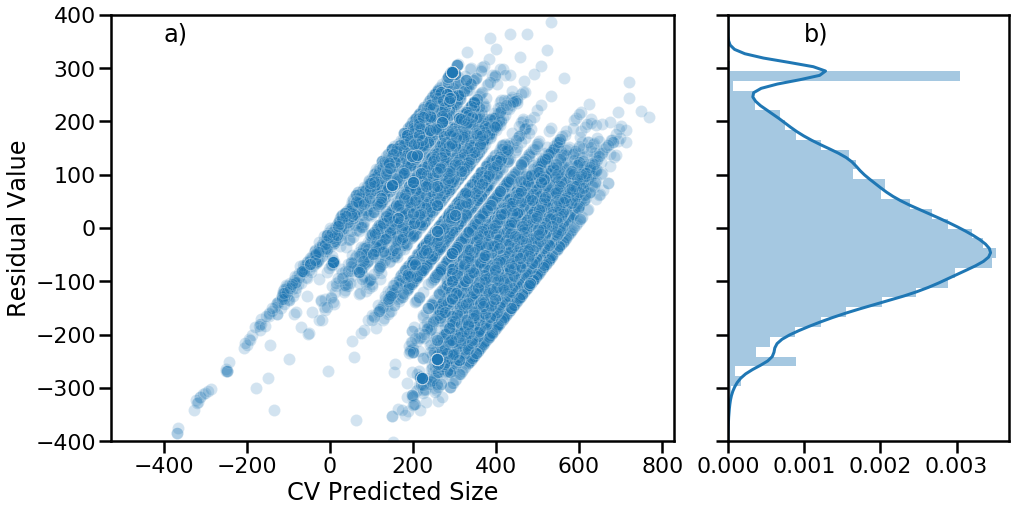

In [17]:
def help_plot_residuals(fitted_model, X, y):
    """
    Utility function:  Plot residual values for a given model
    and features + predictions
    """
    predicted = fitted_model.predict(X)
    residuals = predicted - y
    
    f = plt.figure(figsize=(14, 7), constrained_layout=True)
    gs = f.add_gridspec(3, 3)
    f_ax0 = f.add_subplot(gs[:, :-1])
    f_ax1 = f.add_subplot(gs[:, -1])
    
    # Residuals vs predicted
    sns.scatterplot(x=predicted, y=residuals, alpha=0.2, ax=f_ax0)
    f_ax0.set_xlabel("CV Predicted Size")
    f_ax0.set_ylabel("Residual Value")
    f_ax0.set_ylim((-400, 400))
    f_ax0.text(-400, 350, "a)")
    
    # Hist of residuals
    sns.distplot(a=residuals, hist=True, vertical=True, ax=f_ax1)
    f_ax1.set_ylim((-400, 400))
    f_ax1.set_yticklabels([])
    f_ax1.text(0.001, 350, "b)")

help_plot_residuals(clf.best_estimator_, X_train, y_train)

plt.savefig("outputs/RSS_kmeans_LR_residual.png")

In [18]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

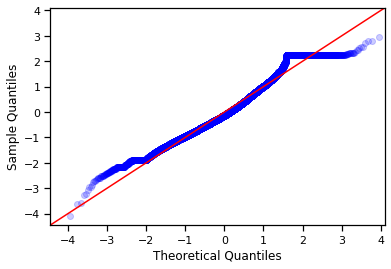

In [22]:
sns.set_context("notebook")
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.2)
plt.savefig("outputs/RSS_kmeans_LR_QQ.png")
plt.show()

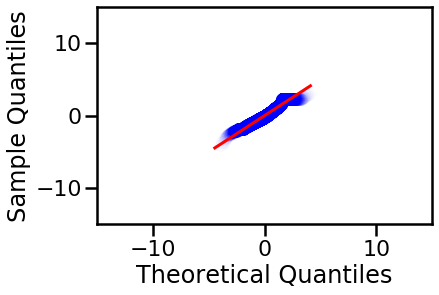

In [20]:
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.02)
fig.axes[0].set_xlim(-15, 15)
fig.axes[0].set_ylim(-15, 15)
plt.show()

## Examine feature significance using an equivalent model in StatsModels

In [21]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train